<a href="https://colab.research.google.com/github/ICYEZAGATORE/alu-machine_learning/blob/main/Tuberculosis_(TB)_Chest_X_ray_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tuberculosis (TB) is an infectious disease caused by Mycobacterium tuberculosis bacteria that primarily affects the lungs and can be transmitted through airborne droplets when infected people cough, sneeze, or speak.

The TB burden in Africa with some key figures:
<font color='red'>

Approximately 2.5 million people fell ill with TB in Africa in 2022

Over 400,000 deaths in 2022, with a high impact on children and immunocompromised populations

High prevalence in South Africa, Nigeria, Ethiopia, Democratic Republic of Congo, and Tanzania

</font>

TB diagnosis in Africa is traditionally performed using chest X-ray imaging and laboratory tests:

Patient chest X-ray (radiography)

Laboratory confirmation through sputum smear or molecular testing

Main issues related to traditional diagnosis in Africa:
<font color='#ed7d31'>

Limited access to diagnostic facilities and radiologists in rural regions

Time-consuming testing and delays in starting treatment

Variability in diagnostic accuracy due to limited expertise and high workload

</font>

The objective of this notebook is to apply modern deep learning techniques to perform automated chest X-ray analysis for TB detection in African populations, improving accessibility, speed, and consistency of diagnosis.

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iraisicyezagatore","key":"e3b1b2c61df671c14dc017d79bada23e"}'}

In [ ]:
# Making a directory for Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Downloading the Data

In [ ]:
# Downloading the dataset using Kaggle API
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

# Unzipping dataset into a folder
!unzip tuberculosis-tb-chest-xray-dataset.zip -d ./TB_dataset


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 95% 628M/663M [00:03<00:00, 50.5MB/s]
100% 663M/663M [00:03<00:00, 187MB/s] 
Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: ./TB_dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: ./TB_dataset/TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: ./TB_dataset/TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: ./TB_dataset/TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: ./TB_dataset/TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: ./TB_dataset/TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: ./TB_dataset/TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: ./TB_dataset/TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: ./TB_dataset/TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: ./TB_dataset/T

Importing Libraries

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ensure reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
data_dir = './TB_dataset'
print(os.listdir(data_dir))


['TB_Chest_Radiography_Database']


Dataset Exploration & Integrity Check

Before training the model, it is important to examine the Tuberculosis Chest X-ray dataset to understand its structure and ensure data quality. This step involved identifying the two main classes (Normal and Tuberculosis), counting the number of images in each to assess class balance, and checking for any corrupted or unreadable image files that could interrupt training. The images were also analyzed for size variations to determine whether resizing would be necessary for consistency during preprocessing. Ensuring that all files were valid and properly formatted helped confirm that the dataset was clean, balanced, and ready for further steps such as augmentation, normalization, and model training.


In [ ]:
data_dir = './TB_dataset/TB_Chest_Radiography_Database'
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print("Classes found:", classes)

# Step 1: Count images per class
print("\n--- Image counts per class ---")
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    num_images = len(os.listdir(cls_path))
    print(f"Class '{cls}': {num_images} images")

# Step 2: Check for corrupted images
corrupted_files = []

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    for img_file in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_file)
        try:
            img = Image.open(img_path)
            img.verify()  # Verify if image can be opened
        except (IOError, SyntaxError):
            corrupted_files.append(img_path)

if corrupted_files:
    print("\nCorrupted / unreadable files found:")
    for f in corrupted_files:
        print(f)
else:
    print("\nNo corrupted files found. All images are readable.")

# Step 3: Check image sizes
image_sizes = []

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    for img_file in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_file)
        img = Image.open(img_path)
        image_sizes.append(img.size)  # (width, height)

print("\nSample image sizes (first 10):", image_sizes[:10])
print("Unique image sizes in dataset:", set(image_sizes))


Classes found: ['Tuberculosis', 'Normal']

--- Image counts per class ---
Class 'Tuberculosis': 700 images
Class 'Normal': 3500 images

No corrupted files found. All images are readable.

Sample image sizes (first 10): [(512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512)]
Unique image sizes in dataset: {(512, 512)}


Data Augmentation and Normalisation


This step prepares the chest X-ray dataset for model training by applying real-time data augmentation and normalization. Augmentation introduces variations such as small rotations, shifts, zooming, and horizontal flips to help the model generalize better and prevent overfitting. Each image is rescaled so that pixel values range between 0 and 1, ensuring consistent input to the neural network. A validation split of 20% is used to monitor model performance during training. The `train_datagen` generator applies both augmentation and normalization to the training images, while the `val_datagen` generator applies only normalization to the validation images to maintain evaluation consistency.



In [ ]:
# Training data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',  # TB vs Normal
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator (only normalization, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = val_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)


Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


CNN Model Definition

Defining the model all it's layers and activation functions

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_cnn(input_shape=(224,224,3)):
    model = Sequential([
        # Conv Block 1
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        # Conv Block 2
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        # Conv Block 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        # Flatten + Dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification: TB vs Normal
    ])
    return model

cnn_model = build_cnn()
cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,457 (49.36 MB)

 Trainable params: 12,939,009 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

Compiling the CNN

In [ ]:
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)



Callbacks Optimisation


To improve training stability and efficiency, two callbacks are used: `EarlyStopping` and `ReduceLROnPlateau`. Early stopping monitors the validation loss and stops training if performance no longer improves, preventing overfitting. The learning rate scheduler automatically reduces the learning rate when progress slows, helping the model converge more smoothly.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)


Training the CNN

Training the model in 20 epochs

In [ ]:
history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 475s 4s/step - accuracy: 0.8714 - loss: 3.1589 - val_accuracy: 0.2893 - val_loss: 11.8558 - learning_rate: 0.0010
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 503s 5s/step - accuracy: 0.9290 - loss: 0.5535 - val_accuracy: 0.3702 - val_loss: 7.4635 - learning_rate: 0.0010
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 477s 5s/step - accuracy: 0.9218 - loss: 0.3399 - val_accuracy: 0.6786 - val_loss: 0.7479 - learning_rate: 0.0010
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accuracy: 0.9267 - loss: 0.1968 - val_accuracy: 0.8464 - val_loss: 4.0265 - learning_rate: 0.0010
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 483s 5s/step - accuracy: 0.9259 - loss: 0.2275 - val_accuracy: 0.8619 - val_loss: 0.3900 - learning_rate: 0.0010
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 474s 5s/step - accuracy: 0.9402 - loss: 0.1857 - val_accuracy: 0.8405 - val_loss: 23.1653 - learning_rate: 0.0010
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 474s 5s/step - accuracy: 0.9361 - loss: 

Evaluation and Metrics:

Plotting the confusion matrix and evaluation recall f1, precision and support

27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 819ms/step - accuracy: 0.9918 - loss: 0.0253
Validation Accuracy: 98.33%
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 821ms/step


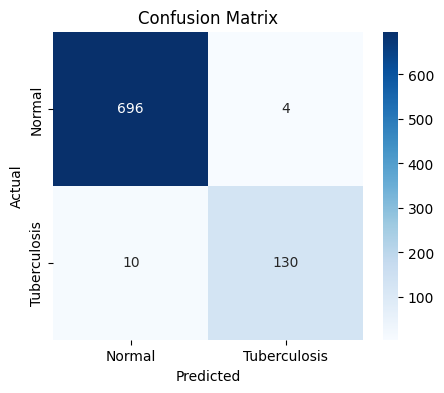

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       700
Tuberculosis       0.97      0.93      0.95       140

    accuracy                           0.98       840
   macro avg       0.98      0.96      0.97       840
weighted avg       0.98      0.98      0.98       840



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate
val_loss, val_acc = cnn_model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

# Confusion Matrix
val_gen.reset()
y_true = val_gen.classes
y_pred = (cnn_model.predict(val_gen) > 0.5).astype("int32").reshape(-1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=classes))


Transfer learning ResNet50

Starting by importing libraries that are relevant to ResNet50


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten




Load and inspect pretrained Model

In this cell, we load the ResNet50 model pre-trained on ImageNet, excluding its top (classification) layers. This allows us to use it as a feature extractor for our own dataset. We then freeze all layers so their weights won’t be updated during training, which helps retain the learned features and speeds up training. Finally, we print the model summary to inspect its architecture, including the number of layers and output shapes.

In [ ]:
# Load ResNet50 (ImageNet weights, exclude top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers for feature extraction
for layer in base_model.layers:
    layer.trainable = False

# Check summary
base_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Building The Model

In this cell, we create a new model on top of the pre-trained ResNet50 base. First, we apply global average pooling to convert the 2D feature maps into a 1D vector. We then add dropout layers for regularization to prevent overfitting, followed by a dense layer to learn high-level features from the extracted representations. Finally, a sigmoid-activated dense layer is used for binary classification. We compile the model with the Adam optimizer, a small learning rate for fine-tuning, and binary cross-entropy loss. Printing the summary shows the complete model architecture, including trainable parameters in the new layers

In [ ]:
# Build Transfer Learning Model
x = base_model.output
x = GlobalAveragePooling2D()(x)        # Convert feature maps to vector
x = Dropout(0.3)(x)                    # Regularization
x = Dense(128, activation='relu')(x)   # Learn high-level features
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_resnet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Train model

Training the ResNet50 model in 10 epochs

In [ ]:
#Train ResNet50 Transfer Learning Model
history_resnet = model_resnet.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 522s 5s/step - accuracy: 0.7236 - loss: 0.5928 - val_accuracy: 0.8333 - val_loss: 0.4558
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 535s 5s/step - accuracy: 0.8287 - loss: 0.4801 - val_accuracy: 0.8333 - val_loss: 0.4489
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 533s 5s/step - accuracy: 0.8340 - loss: 0.4798 - val_accuracy: 0.8333 - val_loss: 0.4497
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 544s 5s/step - accuracy: 0.8221 - loss: 0.5003 - val_accuracy: 0.8333 - val_loss: 0.4488
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 541s 5s/step - accuracy: 0.8475 - loss: 0.4549 - val_accuracy: 0.8333 - val_loss: 0.4538
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 532s 5s/step - accuracy: 0.8299 - loss: 0.4731 - val_accuracy: 0.8333 - val_loss: 0.4515
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 533s 5s/step - accuracy: 0.8340 - loss: 0.4575 - val_accuracy: 0.8333 - val_loss: 0.4514
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 522s 5s/step - accuracy: 0.8189 - loss: 0.4891 - val_accu

Saving the Model for future use

In [ ]:
model_resnet.save('ResNet50_TB_model.h5')


Plotting trainining History

Plotting the Loss and accuracy graphs for booth training and validation

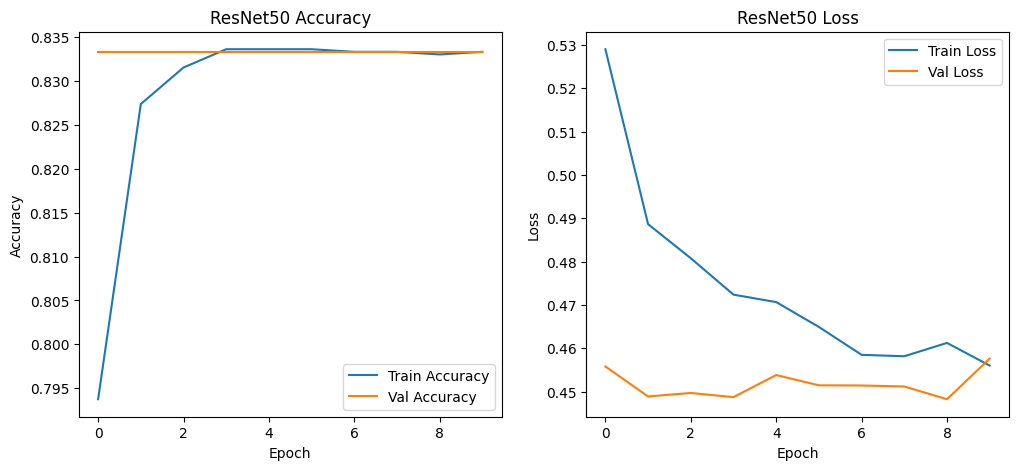

In [ ]:
#  Plot Training vs Validation Accuracy & Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


VGG16

Start by importing libraries that are relevant to the model

In [ ]:
# ===========================
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten


Load and inspect pretrained basee model

we load the VGG16 model pre-trained on ImageNet, excluding its top (classification) layers. This allows us to use it as a feature extractor for our own dataset. We then freeze all layers so their weights won’t be updated during training, which helps retain the learned features and speeds up training. Finally, we print the model summary to inspect its architecture, including the number of layers and output shapes.

In [ ]:
# Load VGG16 (ImageNet weights, exclude top layers)
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional base
for layer in base_model_vgg.layers:
    layer.trainable = False

# Display summary
base_model_vgg.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Building the model

In this cell, we build a transfer learning model using a pre-trained VGG16 base. The convolutional features from VGG16 are first flattened into a 1D vector. We then add a fully connected dense layer to learn high-level representations, followed by a dropout layer to reduce overfitting. The final dense layer with a sigmoid activation performs binary classification (e.g., TB vs. Normal). The model is compiled with the Adam optimizer, a low learning rate for fine-tuning, and binary cross-entropy loss. The summary displays the complete model structure, highlighting the new trainable layers added on top of VGG16.

In [ ]:
# Build Transfer Learning Model (VGG16)
x = base_model_vgg.output
x = Flatten()(x)                      # Flatten convolutional features
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.4)(x)                   # Regularization
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (TB vs Normal)

model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions)

# Compile the model
model_vgg.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_vgg.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Training the model:

Training the model in  10 epochs

In [20]:
# Train VGG16 Transfer Learning Model
history_vgg = model_vgg.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2266s 22s/step - accuracy: 0.8818 - loss: 0.2887 - val_accuracy: 0.9524 - val_loss: 0.1179
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2264s 22s/step - accuracy: 0.9550 - loss: 0.1198 - val_accuracy: 0.9762 - val_loss: 0.0709
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2234s 21s/step - accuracy: 0.9740 - loss: 0.0729 - val_accuracy: 0.9798 - val_loss: 0.0584
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2232s 21s/step - accuracy: 0.9833 - loss: 0.0604 - val_accuracy: 0.9845 - val_loss: 0.0505
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2235s 21s/step - accuracy: 0.9776 - loss: 0.0608 - val_accuracy: 0.9869 - val_loss: 0.0488
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2235s 21s/step - accuracy: 0.9863 - loss: 0.0433 - val_accuracy: 0.9869 - val_loss: 0.0481
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2230s 21s/step - accuracy: 0.9849 - loss: 0.0435 - val_accuracy: 0.9845 - val_loss: 0.0369
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2229s 21s/step - accuracy: 0.9833 - loss: 0

Saving model

In [21]:
#  Save Model for Future Use
model_vgg.save('VGG16_TB_model.h5')


Plotting Training History

Plotting the accuracy and loss graph for both training and validation

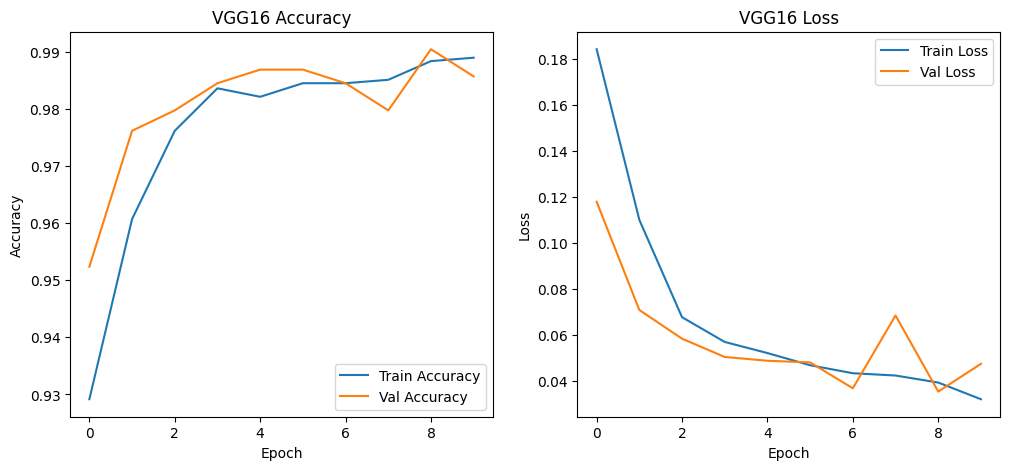

In [22]:
#  Plot Training vs Validation Accuracy & Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Val Accuracy')
plt.title('VGG16 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Val Loss')
plt.title('VGG16 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


VGG16 Confusion matrix

Plotting the Confusion matrix of the VGG16 model

27/27 ━━━━━━━━━━━━━━━━━━━━ 464s 17s/step


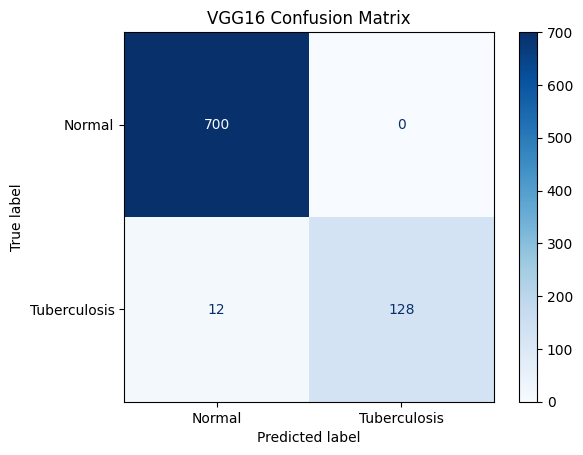

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#  Confusion Matrix
# =======================
val_preds = model_vgg.predict(val_gen)
val_labels = val_gen.classes
val_preds_classes = (val_preds > 0.5).astype(int).ravel()

cm = confusion_matrix(val_labels, val_preds_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_gen.class_indices.keys()))
disp.plot(cmap='Blues', values_format='d')
plt.title('VGG16 Confusion Matrix')
plt.show()


ROC Curve and AUC

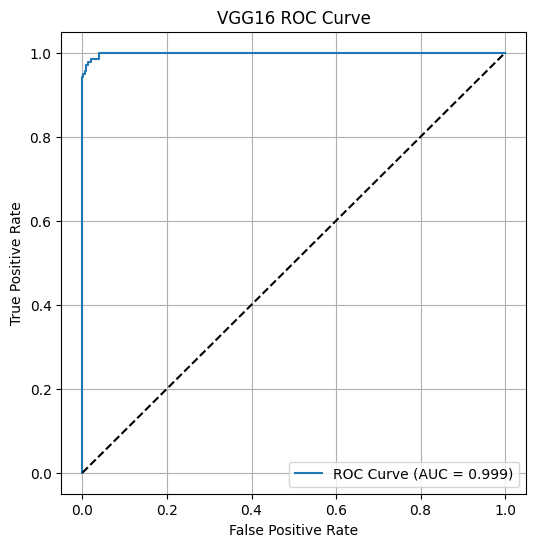

In [24]:
from sklearn.metrics import roc_curve, auc
# ROC Curve & AUC
fpr, tpr, _ = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('VGG16 ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()
